In [1]:
import torch
from torch.utils.data import Dataset
from astropy.io import fits
import astropy.units as u
from astropy.time import Time

import numpy as np
from arccnet.visualisation import utils as ut_v
from scipy.ndimage import rotate
import sunpy.map
import pandas as pd
import os
from arccnet.models import labels

import torchvision
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

img_size_dic = {'MDI': 1024, 'HMI': 4096}

In [2]:
data_folder = os.getenv('ARCAFF_DATA_FOLDER', '../../../data/')
dataset_folder = 'arccnet-fulldisk-dataset-v20240917'
df_name = 'fulldisk-detection-catalog-v20240917.parq'

df = pd.read_parquet(os.path.join(data_folder, dataset_folder, df_name))
df['time'] = df['datetime.jd1'] + df['datetime.jd2']
times = Time(df['time'], format='jd')
df['datetime'] = pd.to_datetime(times.iso)

selected_df  = df[df['filtered'] == False]

lon_trshld = 70
front_df = selected_df[(selected_df['longitude'] < lon_trshld) & (selected_df['longitude'] > -lon_trshld)]

min_size = 0.024
img_size_dic = {
    'MDI': 1024,
    'HMI': 4096}

cleaned_df = front_df.copy()
for idx, row in cleaned_df.iterrows():
    x_min, y_min = row['bottom_left_cutout']
    x_max, y_max = row['top_right_cutout']

    img_sz = img_size_dic.get(row['instrument'])
    width = (x_max - x_min) / img_sz
    height = (y_max - y_min) / img_sz
    
    cleaned_df.at[idx, 'width'] = width
    cleaned_df.at[idx, 'height'] = height

cleaned_df = cleaned_df[(cleaned_df['width'] >= min_size) & (cleaned_df['height'] >= min_size)]

cleaned_df

,target_time.jd1,target_time.jd2,datetime.jd1,datetime.jd2,instrument,path,processed_path_image,target_time_arc.jd1,target_time_arc.jd2,datetime_arc.jd1,...,record_TARPNUM_arc,record_TARPNUM_arc.mask,record_HARPNUM_arc,record_HARPNUM_arc.mask,quicklook_path,quicklook_path.mask,time,datetime,width,height
30,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,52,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.108398,0.062500
31,2450262.0,0.5,2450263.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450262.0,0.5,2450263.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450263e+06,1996-06-28 00:01:30.000,0.082031,0.058594
32,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.068359,0.059570
33,2450264.0,-0.5,2450264.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,-0.5,2450264.0,...,52,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450264e+06,1996-06-29 00:01:30.000,0.110352,0.060547
34,2450264.0,0.5,2450265.0,-0.498958,MDI,arccnet_data/02_intermediate/data/mag/fits/mdi...,arccnet_data/03_processed/data/mag/fits/mdi/md...,2450264.0,0.5,2450265.0,...,49,False,0,True,arccnet_data/04_final/data/region_detection/qu...,False,2.450265e+06,1996-06-30 00:01:30.000,0.051758,0.059570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27389,2459818.0,0.5,2459818.0,0.499111,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459818.0,0.5,2459818.0,...,0,True,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459818e+06,2022-08-26 23:58:43.200,0.146240,0.056396
27390,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8540,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.145508,0.057373
27391,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8546,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.186279,0.108398
27392,2459820.0,-0.5,2459819.0,0.499110,HMI,arccnet_data/02_intermediate/data/mag/fits/hmi...,arccnet_data/03_processed/data/mag/fits/hmi/hm...,2459820.0,-0.5,2459819.0,...,0,True,8539,False,arccnet_data/04_final/data/region_detection/qu...,False,2.459819e+06,2022-08-27 23:58:43.100,0.085937,0.064697


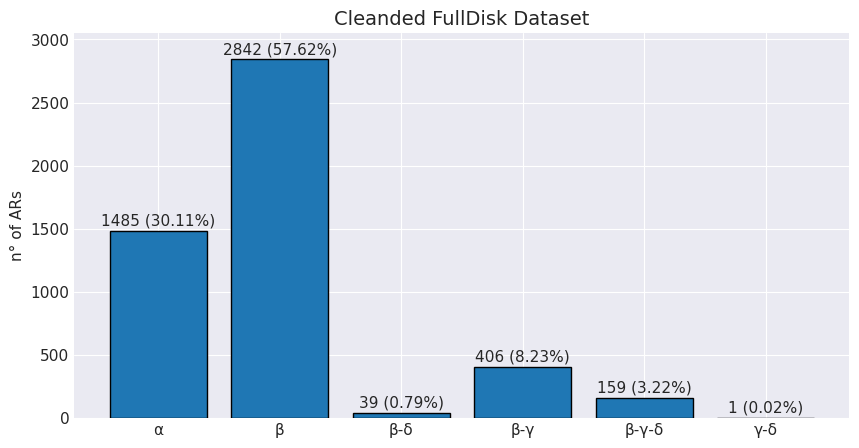

In [3]:
ut_v.make_classes_histogram(
    cleaned_df['magnetic_class'], 
    y_off=20, figsz=(10, 5), title='Cleanded FullDisk Dataset', ylim = 3050, bar_color='#1f77b4')

In [4]:
label_mapping = {
    "Alpha": "Alpha",
    "Beta": "Beta",
    "Beta-Delta": "Beta",
    "Beta-Gamma": "Beta-Gamma",
    "Beta-Gamma-Delta": "Beta-Gamma",
    "Gamma": "None",
    "Gamma-Delta": "None",
}

unique_labels = cleaned_df["magnetic_class"].map(label_mapping).unique()
label_to_index = {label: idx for idx, label in enumerate(unique_labels, start=1)}  # Start from 1

# Update DataFrame
cleaned_df["grouped_label"] = cleaned_df["magnetic_class"].map(label_mapping)
cleaned_df = cleaned_df[cleaned_df["grouped_label"] != "None"].copy()  # Exclude 'None' labels if necessary
cleaned_df["encoded_label"] = cleaned_df["grouped_label"].map(label_to_index)

In [5]:
class FulldiskDataset(Dataset):
    def __init__(self, df, local_path_root, transform=None):
        self.df = df
        self.local_path_root = local_path_root
        self.transform = transform
        self.img_size_dic = img_size_dic  # Add this to use img size dictionary

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        arccnet_path_root = row["path"].split("/fits")[0]
        image_path = row["path"].replace(arccnet_path_root, self.local_path_root)
        
        # Load data with FITS and SunPy
        with fits.open(image_path) as img_fit:
            data = img_fit[1].data
            header = img_fit[1].header
        sunpy_map = sunpy.map.Map(data, header)

        # Mask off-disk
        x, y = np.meshgrid(np.arange(sunpy_map.data.shape[1]), np.arange(sunpy_map.data.shape[0]))
        coordinates = sunpy_map.pixel_to_world(x * u.pix, y * u.pix)
        solar_radius = sunpy_map.rsun_obs
        on_disk = coordinates.separation(sunpy_map.reference_coordinate) <= solar_radius
        sunpy_map.data[~on_disk] = np.nan
        
        # Transformations
        data = np.nan_to_num(sunpy_map.data, nan=0.0)
        data = ut_v.hardtanh_transform_npy(data)
        crota2 = header.get('CROTA2', 0)
        data = rotate(data, crota2, reshape=False, mode='constant', cval=0)

        data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        data = TF.resize(data, [1024, 1024])

        if self.transform:
            data = self.transform(data)

        # Extract label
        label = row['encoded_label']

        # Compute bounding box
        img_sz = img_size_dic.get(row['instrument'])
        scale_factor = 1024 / img_sz
        x_min, y_min = row['bottom_left_cutout']
        x_max, y_max = row['top_right_cutout']
        bbox = [
            x_min * scale_factor,
            y_min * scale_factor,
            x_max * scale_factor,
            y_max * scale_factor,
        ]  # Absolute coordinates

        # Structure for Faster R-CNN
        target = {
            'boxes': torch.tensor([bbox], dtype=torch.float32),
            'labels': torch.tensor([label], dtype=torch.int64),
        }

        return data, target

In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
model.backbone.body.conv1 = torch.nn.Conv2d(
    1, 64, kernel_size=7, stride=2, padding=3, bias=False
)
num_classes = 4  # 3 AR classes + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
# Hyperparameters
learning_rate = 0.005
num_epochs = 10

In [8]:
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# DataLoader
local_path_root = os.path.join(data_folder, dataset_folder)
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

train_dataset = FulldiskDataset(cleaned_df, local_path_root, transform=None)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=16,
    collate_fn=collate_fn,
)

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in tqdm(train_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    scheduler.step()

  0%|          | 0/2466 [00:51<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[2, 3, 800, 800] to have 1 channels, but got 3 channels instead